# Correcting absolute hydration free energies using support vector machines - null test

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Global-variables" data-toc-modified-id="Global-variables-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Global variables</a></span></li><li><span><a href="#Path-variables" data-toc-modified-id="Path-variables-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Path variables</a></span><ul class="toc-item"><li><span><a href="#Convergence-plot" data-toc-modified-id="Convergence-plot-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Convergence plot</a></span></li></ul></li><li><span><a href="#External-testing" data-toc-modified-id="External-testing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>External testing</a></span><ul class="toc-item"><li><span><a href="#Load-test-data" data-toc-modified-id="Load-test-data-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Load test data</a></span></li><li><span><a href="#Predict-$\Delta-G_{hydr}$" data-toc-modified-id="Predict-$\Delta-G_{hydr}$-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Predict $\Delta G_{hydr}$</a></span></li></ul></li></ul></div>

## Imports

In [1]:
# General:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import csv
import time
import scipy
import shutil
import logging
import pickle
import statistics
from tqdm import tqdm_notebook as tqdm
from uncertainties import unumpy

# SVM:
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from skopt import gp_minimize, dump, load

# SciKit-Optimise:
from skopt import gp_minimize, dump
from skopt.space import Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Global variables

In [2]:
# Global variables:
model_type = 'null_DNN'
# label_col = 'Experimental dGhydr (kcal/mol)'
label_col = 'dGoffset (kcal/mol)'
label_u_col = 'uncertainty (kcal/mol)'

# set data processing configurations:
n_calls = 60  # Number of Bayesian optimisation loops for hyperparameter optimisation, 40 is best for convergence, > 60 scales to very expensive
best_mae = np.inf  # Point to consider top-performing model from (MAE/MAD); 1.0 = no improvement on test-set variance

# KFold parameters:
n_splits = 5  # Number of K-fold splits
random_state = 2  # Ranom number seed

# DNN global variables
n_calls = 60  # Number of Bayesian optimisation loops for hyperparameter optimisation, 40 is best for convergence, > 60 scales to very expensive
epochs = 200
best_mae = np.inf

## Path variables

In [3]:
# Path variables:
path = './'
datasets_dr = '../datasets/'
SDF_dr = datasets_dr + 'sdffiles/'
output_dr = path + 'output_null/'
if not os.path.exists(output_dr):
    os.mkdir(output_dr)
figures_dr = path + 'figures_null/'
if not os.path.exists(figures_dr):
    os.mkdir(figures_dr)
freesolv_loc = datasets_dr + 'freesolv_database.txt'

### Convergence plot

Load gp_minimize objects

In [4]:
# gp_minimize object
gp_results = [load(output_dr + 'fold_' + str(fold_num) +  '_gp_minimize_result.pickle') 
              for fold_num in range(1, n_splits + 1)]
# lsit of MAE and associated parameters
mae_logger = pd.read_csv(output_dr + 'DNN_statistics.csv')

/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.20.0 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Plot function convergence over number of calls

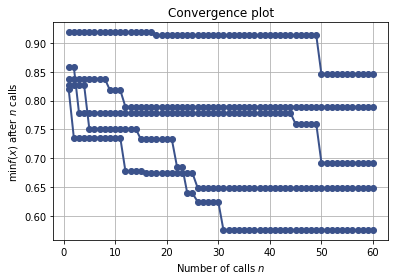

In [5]:
for result in gp_results: plot_convergence(result)
plt.savefig(figures_dr + 'convergence_plot.png')

## External testing

### Load test data

In [9]:
test_X = pd.read_csv(datasets_dr + 'test_data.csv',
                     index_col='ID').iloc[:,0:-2]

test_y = pd.read_csv(filepath_or_buffer=datasets_dr + 'test_data.csv',
                     index_col='ID').iloc[:,-2:-1]

In [11]:
# load experimetnal dGhydr column from freesolv
exp_dGhydr = pd.read_csv(filepath_or_buffer=datasets_dr + 'freesolv_database.txt',
                         sep='; ',
                         engine='python',
                         usecols=['compound id (and file prefix)', 'experimental value (kcal/mol)'],
                         index_col='compound id (and file prefix)'
                        ).sort_index()

### Predict $\Delta G_{hydr}$

In [12]:
def model_predict(model_num, test_entry):
    """Load model from HDF5 and return model prediction on a given test_entry."""

    model = tf.keras.models.load_model(output_dr + 'dGhydr_DNN_fold_' + str(model_num) + '_model.h5')

    return model.predict(test_entry)

In [ ]:
import tensorflow as tf
output_dr = './output_null/'
model_1 = tf.keras.models.load_model(output_dr + 'dGhydr_DNN_fold_1_model.h5')

In [ ]:
# ML predicted labels nested list per fold
predict_per_fold = [model_predict(fold_num, test_X) for fold_num in range(1, n_splits + 1)]
# average ML predicted labels
predict_y = np.average(predict_per_fold, axis=0)
# convert np array to float
predict_y = [float(x) for x in predict_y]

In [ ]:
!ls ./output_null

In [ ]:
def plot_scatter(x, y, title, x_label, y_label):
    """
    Returns and saves linear regression scatter plot.
    x: (list) calculated or predicted data.
    y: (list) true or experimental data.
    title: (str) plot title and filename delimitted by underscores. Avoid special characters.
    x_label: (str) x-axis label.
    y_label: (str) y-axis label.
    """
    
    # plot scatter
    plt.figure()
    plt.scatter(x, y, color='black', s=8)

    # plot line of best fit
    # https://stackoverflow.com/questions/22239691/code-for-best-fit-straight-line-of-a-scatter-plot-in-python
    plt.plot(np.unique(x),
             np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),
             color='black', linewidth=1)

    # axis labels
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # figure title
    plt.title(title)

    # absolute error
    ae = [abs(i - j) for i, j in zip(x, y)]
    # mean absolute error
    mae = statistics.mean(ae)
    
    # R-squared
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y, x)
    r2 = r_value**2

    # annotate with r-squared and MAE
    string = 'MAE = {}\nR$^2$ = {}\nR = {}'.format(round(mae, 4), round(r2, 4), round(r_value, 4))
    plt.annotate(string, xy=(0, 1),
                 xytext=(12, -12), va='top',
                 xycoords='axes fraction',
                 textcoords='offset points')

    filename = figures_dr + str(title).lower().replace(' ', '_') + '.png'
    plt.savefig(filename)
    logging.info('Saved {}.'.format(filename))

In [ ]:
plot_scatter(x=predict_y,
             y=test_y[label_col].tolist(),
             title='{}-predicted hydration free energies'.format(model_type),
             x_label='SVM-predicted $\Delta G_{hydr}$ / kcal mol$^{-1}$',
             y_label='Experimental $\Delta G_{hydr}$ / kcal mol$^{-1}$')

In [ ]:
def generate_statistics(self, comp_data, exp_data, compound_list=None, repeats=1000):
        r"""
        Parameters
        ----------
        comp_data : list of dictionaries
            list of dictionaries of computed free energies and their errors
        exp_data : list of dictionaries
            list of dictionaries of experimental free energies and their errors
        compound_list : list of strings
            list should contain dictionary keys of compounds to be compared statistically
        repeats : integer
            number of times new samples are drawn from the gaussian distribution of the computational data
        """
        self.data_comp = []
        self.data_exp = []

        # Setting up compound list
        if compound_list is None:
            cl_exp = set().union(*(d.keys() for d in exp_data))
            cl_comp = set().union(*(d.keys() for d in comp_data))
            compound_list = list(set(cl_exp).intersection(cl_comp))
            if 'error' in compound_list:
                index = compound_list.index('error')
                compound_list.pop(index)
            self._compound_list = compound_list
        else:
            self._compound_list = compound_list

        # Setting up computed and experimental dictionaries
        for k in self._compound_list:
            comp = next(item for item in comp_data if k in item)
            exp = next(item for item in exp_data if k in item)
            val = comp[k]
            err = comp['error']
            self.data_comp.append([val, err])
            val = exp[k]
            self.data_exp.append(val)

        new_data = np.array(self.data_comp)[:,0]
        self._R_from_data, p = scipy.stats.pearsonr(new_data, np.array(self.data_exp))
        self._tau_from_data = scipy.stats.kendalltau(new_data, np.array(self.data_exp))[0]
        self._rmse_from_data = self._calculate_rmse(new_data, np.array(self.data_exp))
        self._mue_from_data = self._calculate_mue(new_data, np.array(self.data_exp))

        self._R = []
        self._R2 = []
        self._tau = []
        self._mue = []
        self._rmse = []

        # Now generate the data
        for i in range(repeats):
            new_data = []
            for i in range(len(self.data_comp)):
                val = self.data_comp[i][0]
                err = self.data_comp[i][1]
                if err != 0.0:
                    val2 = np.random.normal(val, err)
                    new_data.append(val2)
                else:
                    new_data.append(val)
            R2, R = self._calculate_r2(new_data, self.data_exp)
            tau = self._calculate_tau(new_data, self.data_exp)
            mue = self._calculate_mue(new_data, self.data_exp)
            rmse = self._calculate_rmse(np.array(new_data), np.array(self.data_exp))
            self._R.append(R)
            self._R2.append(R2)
            self._tau.append(tau)
            self._mue.append(mue)
            self._rmse.append(rmse)
